# 5.3-用预训练的CNN（VGG16）识别猫与狗（3）

## 采用微调方式对模型进行训练，对应教材中pp125-130

## 1 载模型
### 读取在“特征提取”章节中已经训练好的模型
### 注意：此时的卷积基为全部冻结状态

In [19]:
from keras.models import load_model 

model = load_model('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/ch5_3_transfer_learning_2_extened_vgg16_with_data_augment_without_droupout.h5') 

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


## 2 解冻顶
## 解冻卷积基中block5的3个卷积层

### 2.1 从模型中获取卷积基部分

In [21]:
conv_base = model.get_layer(name = 'vgg16')

### 2.2 解冻卷积基中block5的3个卷积层，block5中的3个卷积层name分别为block5_conv1, block5_conv2, block5_conv3

In [22]:
#解冻标志位
set_trainable = False

for layer in conv_base.layers :
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

## 3 理图形、调模型

### 3.1 编译之前加载的模型，调减学习率

In [23]:
from keras import optimizers

#学习率从之前的2e-5调整为1e-5,即2 x 10^-5; 1 x 10^-5
model.compile(optimizer = optimizers.RMSprop(lr=1e-5), loss = 'binary_crossentropy', metrics = ['acc'])

### 3.2 训练微调模型

In [24]:
#利用数据生成器生成数据集

from keras.preprocessing.image import ImageDataGenerator

# #配置数据集目录
import os
base_dir = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir, 'test')


#训练数据生成器
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(train_dir,target_size = (150,150), 
                                                     batch_size = 20, 
                                                     class_mode = 'binary')

#测试数据生成器
validation_datagen = ImageDataGenerator(
    rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(validation_dir, 
                                                              target_size = (150,150), 
                                                              batch_size = 20, 
                                                              class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [25]:
history = model.fit_generator(train_generator, 
                                                     epochs = 30, 
                                                     steps_per_epoch = 100, 
                                                     validation_data = validation_generator, 
                                                     validation_steps = 50)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 [==============================] - 358s 4s/step - loss: 0.2964 - acc: 0.8630 - val_loss: 0.2161 - val_acc: 0.9180
Epoch 2/30
100/100 [==============================] - 345s 3s/step - loss: 0.2660 - acc: 0.8930 - val_loss: 0.2100 - val_acc: 0.9170
Epoch 3/30
100/100 [==============================] - 351s 4s/step - loss: 0.2385 - acc: 0.9005 - val_loss: 0.2056 - val_acc: 0.9230
Epoch 4/30
100/100 [==============================] - 349s 3s/step - loss: 0.2226 - acc: 0.9040 - val_loss: 0.1886 - val_acc: 0.9270
Epoch 5/30
100/100 [==============================] - 349s 3s/step - loss: 0.1950 - acc: 0.9165 - val_loss: 0.2018 - val_acc: 0.9200
Epoch 6/30
100/100 [==============================] - 355s 4s/step - loss: 0.1941 - acc: 0.9215 - val_loss: 0.1858 - val_acc: 0.9300
Epoch 7/30
100/100 [==============================] - 350s 3s/step - loss: 0.1774 - acc: 0.9275 - val_loss: 0.1875 - val_acc: 

### 3.3 养成良好习惯，保存训练好的模型及训练历史数据

In [26]:
#保存模型
model.save('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/fine_tun_vgg16_with_CPU_0802.h5')

In [27]:
#保存模型训练历史记录
import pickle
 
with open('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/fine_tun_trainHistoryDict.txt', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)#将训练历史数据保存到指定文件中

## 4 评估模型

### 4.1 读取训练历史数据

In [31]:
with open('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/fine_tun_trainHistoryDict.txt','rb') as file_pi:
    my_history = pickle.load(file_pi)

In [34]:
import matplotlib.pyplot as plt

train_acc = my_history['acc']
val_acc = my_history['val_acc']
train_loss = my_history['loss']
val_loss = my_history['val_loss']

### 4.2 微调模型在训练集、验证集上的预测精度表现

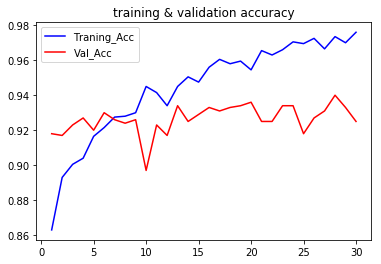

In [35]:
epochs = range(1,len(train_acc)+1)

plt.plot(epochs, train_acc, 'b', label = 'Traning_Acc')
plt.plot(epochs, val_acc, 'r', label = 'Val_Acc')
plt.title('training & validation accuracy')
plt.legend()
plt.show()

### 4.3 微调模型在训练集、测试集上的损失表现

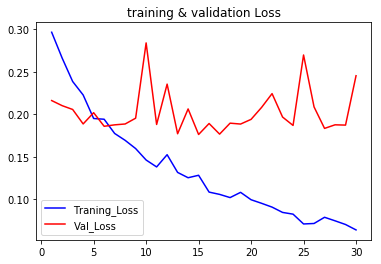

In [36]:
plt.plot(epochs, train_loss, 'b', label = 'Traning_Loss')
plt.plot(epochs, val_loss, 'r', label = 'Val_Loss')
plt.title('training & validation Loss')
plt.legend()
plt.show()

### 4.4 对曲线进行平滑处理
### p(t) = p(t) * 0.8 + p(t-1) * 0.2，即放大上一时刻数值的影响、缩小当前时刻的值影响

In [37]:
#对数值进行平滑处理，即 p(t) = p(t) * 0.8 + p(t-1) * 0.2
def smooth_curve(points):
    smooth_points = [] #平滑后的数值
    for p in points:
        if smooth_points:
            smooth_points.append(0.8 * smooth_points[-1] + 0.2 * p)
        else:
            smooth_points.append(p)       
    return smooth_points

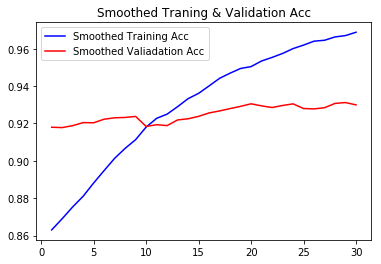

In [38]:
plt.plot(epochs, smooth_curve(train_acc), 'b', label = 'Smoothed Training Acc')
plt.plot(epochs, smooth_curve(val_acc), 'r', label = 'Smoothed Valiadation Acc')
plt.title('Smoothed Traning & Validation Acc')
plt.legend()
plt.show()

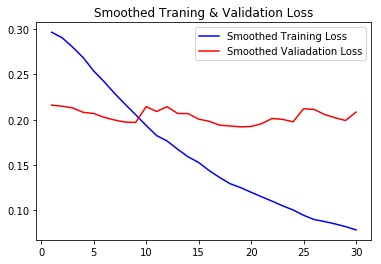

In [39]:
plt.plot(epochs, smooth_curve(train_loss), 'b', label = 'Smoothed Training Loss')
plt.plot(epochs, smooth_curve(val_loss), 'r', label = 'Smoothed Valiadation Loss')
plt.title('Smoothed Traning & Validation Loss')
plt.legend()
plt.show()

## 5 评估测试图片

## 5.1 评估复杂场景图片

In [8]:
from keras.models import load_model
my_network = load_model('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/fine_tun_vgg16_with_CPU.h5')

In [3]:
#定义测试图片预处理函数
import numpy as np
def preprocess_img(img):
    x1 = image.img_to_array(img)
    x2 = x1 * 1./255
    x3 = np.expand_dims(x2, axis = 0)
    return x3

#### 复杂测试场景1：同一图片中存在多只猫

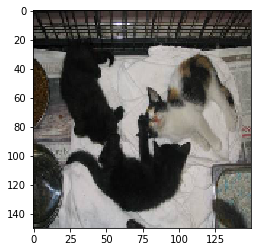

In [13]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
#指定图片存储路径
img_path1 = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/full_dataset_cat_dog/test/cats/cat.12436.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
img1 = image.load_img(img_path1, target_size = (150, 150))
plt.imshow(img1)

In [14]:
pred1 = my_network.predict(preprocess_img(img1))
pred1

array([[0.00671324]], dtype=float32)

#### 微调后的模型预测上述图片为猫

#### 复杂测试场景2：猫/狗以外类别的混合图片

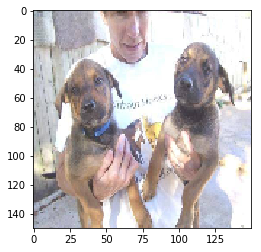

In [10]:
#指定图片存储路径
img_path2 = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/full_dataset_cat_dog/test/dogs/dog.12003.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
img2 = image.load_img(img_path2, target_size = (150, 150))
plt.imshow(img2)

In [11]:
pred2 = my_network.predict(preprocess_img(img2))
pred2

array([[0.9986125]], dtype=float32)

#### 微调后的模型预测上述图片为狗

#### 复杂测试场景3：猫与狗混合图片

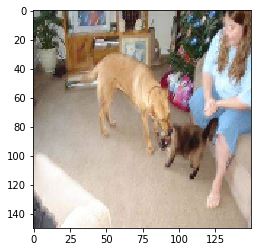

In [15]:
#指定图片存储路径
img_path3 = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/full_dataset_cat_dog/test/dogs/dog.12005.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
img3 = image.load_img(img_path3, target_size = (150, 150))
plt.imshow(img3)

In [16]:
pred3 = my_network.predict(preprocess_img(img3))
pred3

array([[0.99542]], dtype=float32)

#### 微调后的模型预测上述图片为狗

### 5.2 评估测试集图片

In [17]:
import os
from keras.preprocessing import image

classes = ['cats','dogs']
files_name = []
test_true_labels = []
test_pred_labels = []
test_pred_probs = []

for c in classes:
    test_class_dir = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog/test/{}'.format(c)
    for f in os.listdir(test_class_dir):
        
        files_name.append(f)
        test_true_labels.append(f[0:3])
        
        img_path = os.path.join(test_class_dir, f)
        img = image.load_img(img_path, target_size = (150, 150))
        pred = my_network.predict(preprocess_img(img))
        test_pred_probs.append(pred)
        
        pred_label = None
        if pred[0] > 0.5:
            pred_label = 'dog'
        else:
            pred_label = 'cat'
        test_pred_labels.append(pred_label)  

In [18]:
import pandas as pd
df = pd.DataFrame(data={'file':files_name, 'true_label':test_true_labels,  'pred_label':test_pred_labels, 'pred_prob':test_pred_probs})
pred_correct_records = df[df['true_label'] == df['pred_label']].shape[0]
correct_rate = float(pred_correct_records)/float(1000)
error_rate = 1. - correct_rate
print("correct rate: %.2f, error rate: %.2f"%(correct_rate, error_rate))

correct rate: 0.93, error rate: 0.07


#### 微调模型在测试集上的预测正确率可以达到93%